# Sequence Text Classifier 

In [1]:
import pickle
from fastai import *
from fastai.text import *
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 1. DataBunch

Downlow training data, the movie review file

In [2]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/README')]

Turn the data into a datacunch

In [3]:
data_clf = (TextList.from_folder(path)
            .split_by_folder(valid='test')
            .label_from_folder(classes=['neg','pos'])
            .databunch(bs=32, num_workers=1))

## 2. Load pretrained word embedding file

In [0]:
with open('drive/My Drive/Colab Notebooks/encoder_wts.pkl', 'rb') as f:
    E = pickle.load(f)

In [5]:
E.shape

(60000, 400)

In [6]:
emb = torch.from_numpy(E)
emb

tensor([[-0.1916,  0.0589,  0.2372,  ..., -0.0388,  0.4749, -0.1466],
        [ 0.0664,  0.0156, -0.0037,  ...,  0.0152,  0.4083, -0.0193],
        [-0.6573,  0.1963,  1.2365,  ..., -0.4321,  0.8435,  0.4232],
        ...,
        [ 0.2701,  0.0681, -0.0354,  ..., -0.0490,  0.4224, -0.1861],
        [ 0.1707, -0.0179, -0.0843,  ...,  0.0805,  0.4921,  0.1725],
        [ 0.2787,  0.0738, -0.1363,  ...,  0.1366,  0.4673,  0.0541]])

In [0]:
enc_emb = nn.Embedding(60000,400)

In [0]:
enc_emb.weight.data = emb

## 3. Encoder class
The Encoder class is from the Seq2Seq Translation in the Lecture 8 files.

In [0]:
class AttnEncoder(nn.Module):
    def __init__(self, enc_emb, hidden_size, num_layers):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(enc_emb.weight,freeze=False)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(self.emb.embedding_dim,self.hidden_size,
                          num_layers=self.num_layers,bidirectional=True,
                          batch_first=True,dropout=0.2)

    def forward(self,x):

        hidden = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).cuda()
        
        x = self.emb(x)
        out, hidden = self.gru(x,hidden)
        hid = hidden.view(self.num_layers,2,x.size(0),self.hidden_size)
        
        hid_out = torch.cat([hid[0],hid[1]],2)

        output = hid_out[0].squeeze()

        return output, out

## 4. Fully Connected Layer (Model 1)
The fully connected layer has a couple or more linear layers with ReLUs and some dropout layers.

This Model 1 is a simple model. Later we will try other models with more layers.

In [0]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc0 = nn.Linear(self.hidden_size*2, 64)
        self.fc1 = nn.Linear(64,2)
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(0.5)
        
    def forward(self,x):
        hidden = self.fc0(x)
        hidden = self.drop1(hidden)
        hidden = self.relu(hidden)
        hidden = self.fc1(hidden)
        logits = torch.softmax(hidden,1)
        return logits

## 5. The Seq2Seq model with Attention Translation

In [0]:
class AttnSeq2Seq(nn.Module):
    def __init__(self, enc_emb, enc_hidden_size, num_layers):   
        super().__init__()
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers

        self.enc = AttnEncoder(enc_emb, enc_hidden_size, num_layers)
        self.dec = FullyConnectedLayer(enc_hidden_size)
        
    def forward(self, sentence):
        h, out = self.enc(sentence)
        s = self.dec(h)
        return s

In [0]:
model = AttnSeq2Seq(enc_emb, enc_hidden_size=256, num_layers=2).cuda()

## 6. Train and Evaluate model

Make a learner object and train it using the databunch of the movie review data

In [0]:
learn = Learner(data_clf, model, 
                loss_func = nn.CrossEntropyLoss(), 
                metrics = accuracy)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


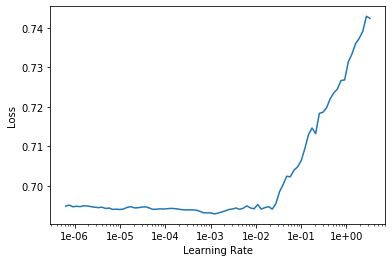

In [15]:
learn.recorder.plot()

In [16]:
learn.fit(10, 5e-3)    

epoch,train_loss,valid_loss,accuracy,time
0,0.561442,0.488309,0.823880,04:50
1,0.497181,0.542415,0.770480,04:46
2,0.506674,0.578982,0.733560,04:54
3,0.509261,0.496051,0.817240,05:21
4,0.533217,0.564702,0.748480,04:31
5,0.551116,0.567374,0.745520,04:52
6,0.696889,0.662730,0.650520,05:18
7,0.552197,0.611097,0.701840,04:53
8,0.601030,0.608437,0.704520,05:16
9,0.625484,0.617298,0.695680,05:24


Result:

- We can see that the 1st epoch has the highest accuracy, which is 0.823880.

## 7. Fully Connected Layer (Model 2)
Now we try some other different architectures for the fully connected layer and see how good accuracy on the test set we can get.

This Model 2 has one more layer than Model 1.

In [0]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc0 = nn.Linear(self.hidden_size*2, 64)
        self.fc1 = nn.Linear(64,32)
        self.fc2 = nn.Linear(32,2)
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(0.4)
        self.drop2 = nn.Dropout(0.5)
        
    def forward(self,x):
        hidden = self.fc0(x)
        hidden = self.drop1(hidden)
        hidden = self.relu(hidden)
        hidden = self.fc1(hidden)
        hidden = self.drop2(hidden)
        hidden = self.relu(hidden)
        hidden = self.fc2(hidden)
        logits = torch.softmax(hidden,1)
        return logits

The other parts are the same with Model 1. The results are shown below.

### The Seq2Seq model with Attention Translation

In [0]:
class AttnSeq2Seq(nn.Module):
    def __init__(self, enc_emb, enc_hidden_size, num_layers):   
        super().__init__()
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers

        self.enc = AttnEncoder(enc_emb, enc_hidden_size, num_layers)
        self.dec = FullyConnectedLayer(enc_hidden_size)
        
    def forward(self, sentence):
        h, out = self.enc(sentence)
        s = self.dec(h)
        return s

In [0]:
model = AttnSeq2Seq(enc_emb, enc_hidden_size=256, num_layers=2).cuda()

### Train and Evaluate model

Make a learner object and train it using the databunch of the movie review data

In [0]:
learn = Learner(data_clf, model, 
                loss_func = nn.CrossEntropyLoss(), 
                metrics = accuracy)

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


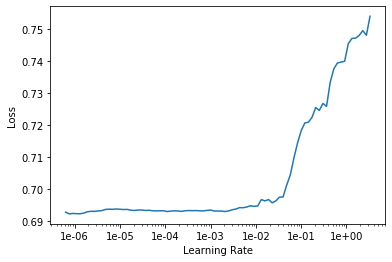

In [23]:
learn.recorder.plot()

In [24]:
learn.fit(10, 5e-3)    

epoch,train_loss,valid_loss,accuracy,time
0,0.535218,0.490910,0.814920,04:30
1,0.570252,0.541093,0.771520,05:26
2,0.519333,0.491489,0.821600,05:16
3,0.510247,0.503530,0.809560,04:54
4,0.567834,0.545264,0.767840,04:33
5,0.543832,0.570583,0.742280,05:00
6,0.517166,0.553178,0.759920,05:09
7,0.617361,0.657033,0.656120,04:50
8,0.514091,0.565249,0.748000,04:40
9,0.528726,0.574866,0.738280,05:07


**Result**:

- We can see that the 3rd epoch has the highest accuracy, which is 0.821600.

## 8. Fully Connected Layer (Model 3)

This Model 3 has one more layer than Model 2.

In [0]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc0 = nn.Linear(self.hidden_size*2, 64)
        self.fc1 = nn.Linear(64,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,2)
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(0.4)
        self.drop2 = nn.Dropout(0.3)
        self.drop3 = nn.Dropout(0.2)
        
    def forward(self,x):
        hidden = self.fc0(x)
        hidden = self.drop1(hidden)
        hidden = self.relu(hidden)
        hidden = self.fc1(hidden)
        hidden = self.drop2(hidden)
        hidden = self.relu(hidden)
        hidden = self.fc2(hidden)
        hidden = self.drop3(hidden)
        hidden = self.relu(hidden)
        hidden = self.fc3(hidden)
        logits = torch.softmax(hidden,1)
        return logits

The other parts are the same with Model 1. The results are shown below.

### The Seq2Seq model with Attention Translation

In [0]:
class AttnSeq2Seq(nn.Module):
    def __init__(self, enc_emb, enc_hidden_size, num_layers):   
        super().__init__()
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers

        self.enc = AttnEncoder(enc_emb, enc_hidden_size, num_layers)
        self.dec = FullyConnectedLayer(enc_hidden_size)
        
    def forward(self, sentence):
        h, out = self.enc(sentence)
        s = self.dec(h)
        return s

In [0]:
model = AttnSeq2Seq(enc_emb, enc_hidden_size=256, num_layers=2).cuda()

### Train and Evaluate model

Make a learner object and train it using the databunch of the movie review data

In [0]:
learn = Learner(data_clf, model, 
                loss_func = nn.CrossEntropyLoss(), 
                metrics = accuracy)

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


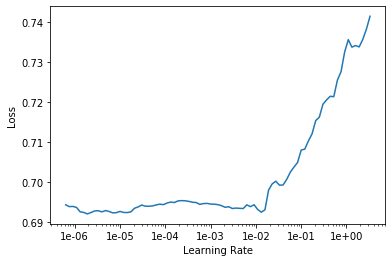

In [38]:
learn.recorder.plot()

In [39]:
learn.fit(10, 5e-3)    

epoch,train_loss,valid_loss,accuracy,time
0,0.521056,0.460102,0.845760,05:19
1,0.458394,0.445581,0.863760,04:31
2,0.468504,0.484677,0.825920,05:15
3,0.430601,0.459793,0.843080,04:59
4,0.469673,0.540419,0.772480,05:06
5,0.465731,0.494755,0.816080,05:10
6,0.467420,0.505420,0.807480,04:40
7,0.499884,0.572676,0.739720,04:46
8,0.522792,0.561192,0.751840,04:27
9,0.549337,0.555581,0.757640,04:35


**Result**:

- We can see that the 2nd epoch has the highest accuracy, which is 0.863760.

## Final Results

Comparing the accuracy results from three models, Model 3 has the highest accuracy, which is  0.863760.

As a result, Model 3 with the most number of layers is the preferred model among the three models.